Vuelva a EMPEZAR!   

[*********************100%%**********************]  24 of 24 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_6908\3387845712.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q[i] = mu[i] - mu[-1]  # Ajuste para ejemplos
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01837093 0.01837093 0.01837093 0.01837093 0.01837093 0.01837093
 0.01837093 0.01837093 0.01837093 0.01837093 0.01837093]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1
C:\Users\filip\AppData\


Sharpe Ratio del Modelo Black-Litterman: 1.60
Sortino Ratio del Modelo Black-Litterman: 0.11
Tracking Error del Modelo Black-Litterman: 15.44%
Beta del Modelo Black-Litterman: 0.85
Volatilidad Anualizada del Modelo Black-Litterman: 0.22
Drawdown Máximo del Modelo Black-Litterman: -40.91%

Sharpe Ratio del Modelo HRP: 0.39
Sortino Ratio del Modelo HRP: -0.04
Tracking Error del Modelo HRP: 17.96%
Beta del Modelo HRP: 0.06
Volatilidad Anualizada del Modelo HRP: 0.06
Drawdown Máximo del Modelo HRP: -17.28%

Sharpe Ratio del Modelo Markowitz: 1.65
Sortino Ratio del Modelo Markowitz: 0.11
Tracking Error del Modelo Markowitz: 13.76%
Beta del Modelo Markowitz: 0.72
Volatilidad Anualizada del Modelo Markowitz: 0.18
Drawdown Máximo del Modelo Markowitz: -33.89%

Rendimiento Anualizado del Modelo Black-Litterman: 38.14%
Volatilidad Anualizada del Modelo Black-Litterman: 21.69%
Sharpe Ratio del Modelo Black-Litterman (Anualizado): 1.60

Rendimiento Anualizado del Modelo HRP: 2.06%
Volatilidad Anu

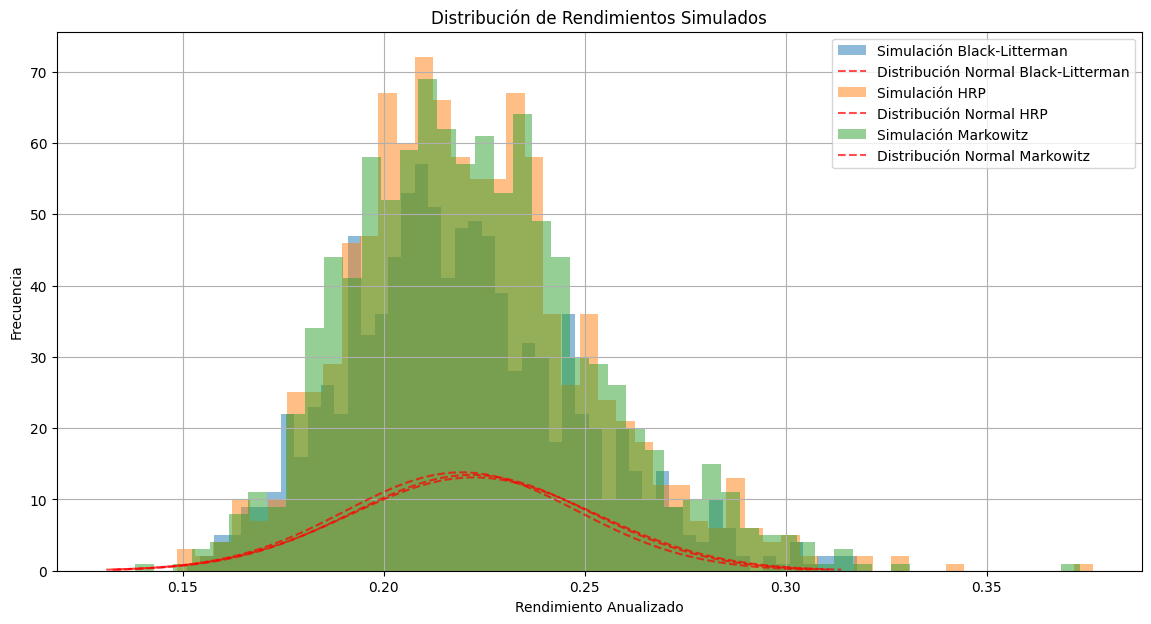

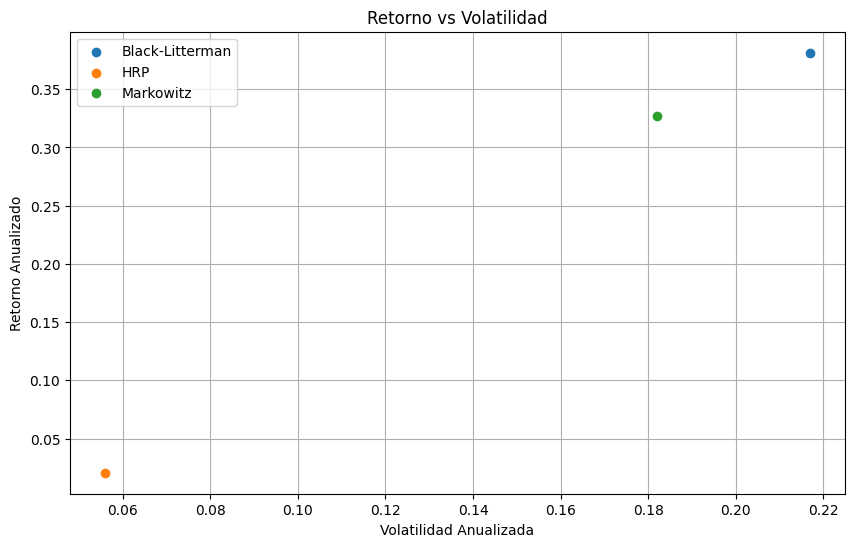

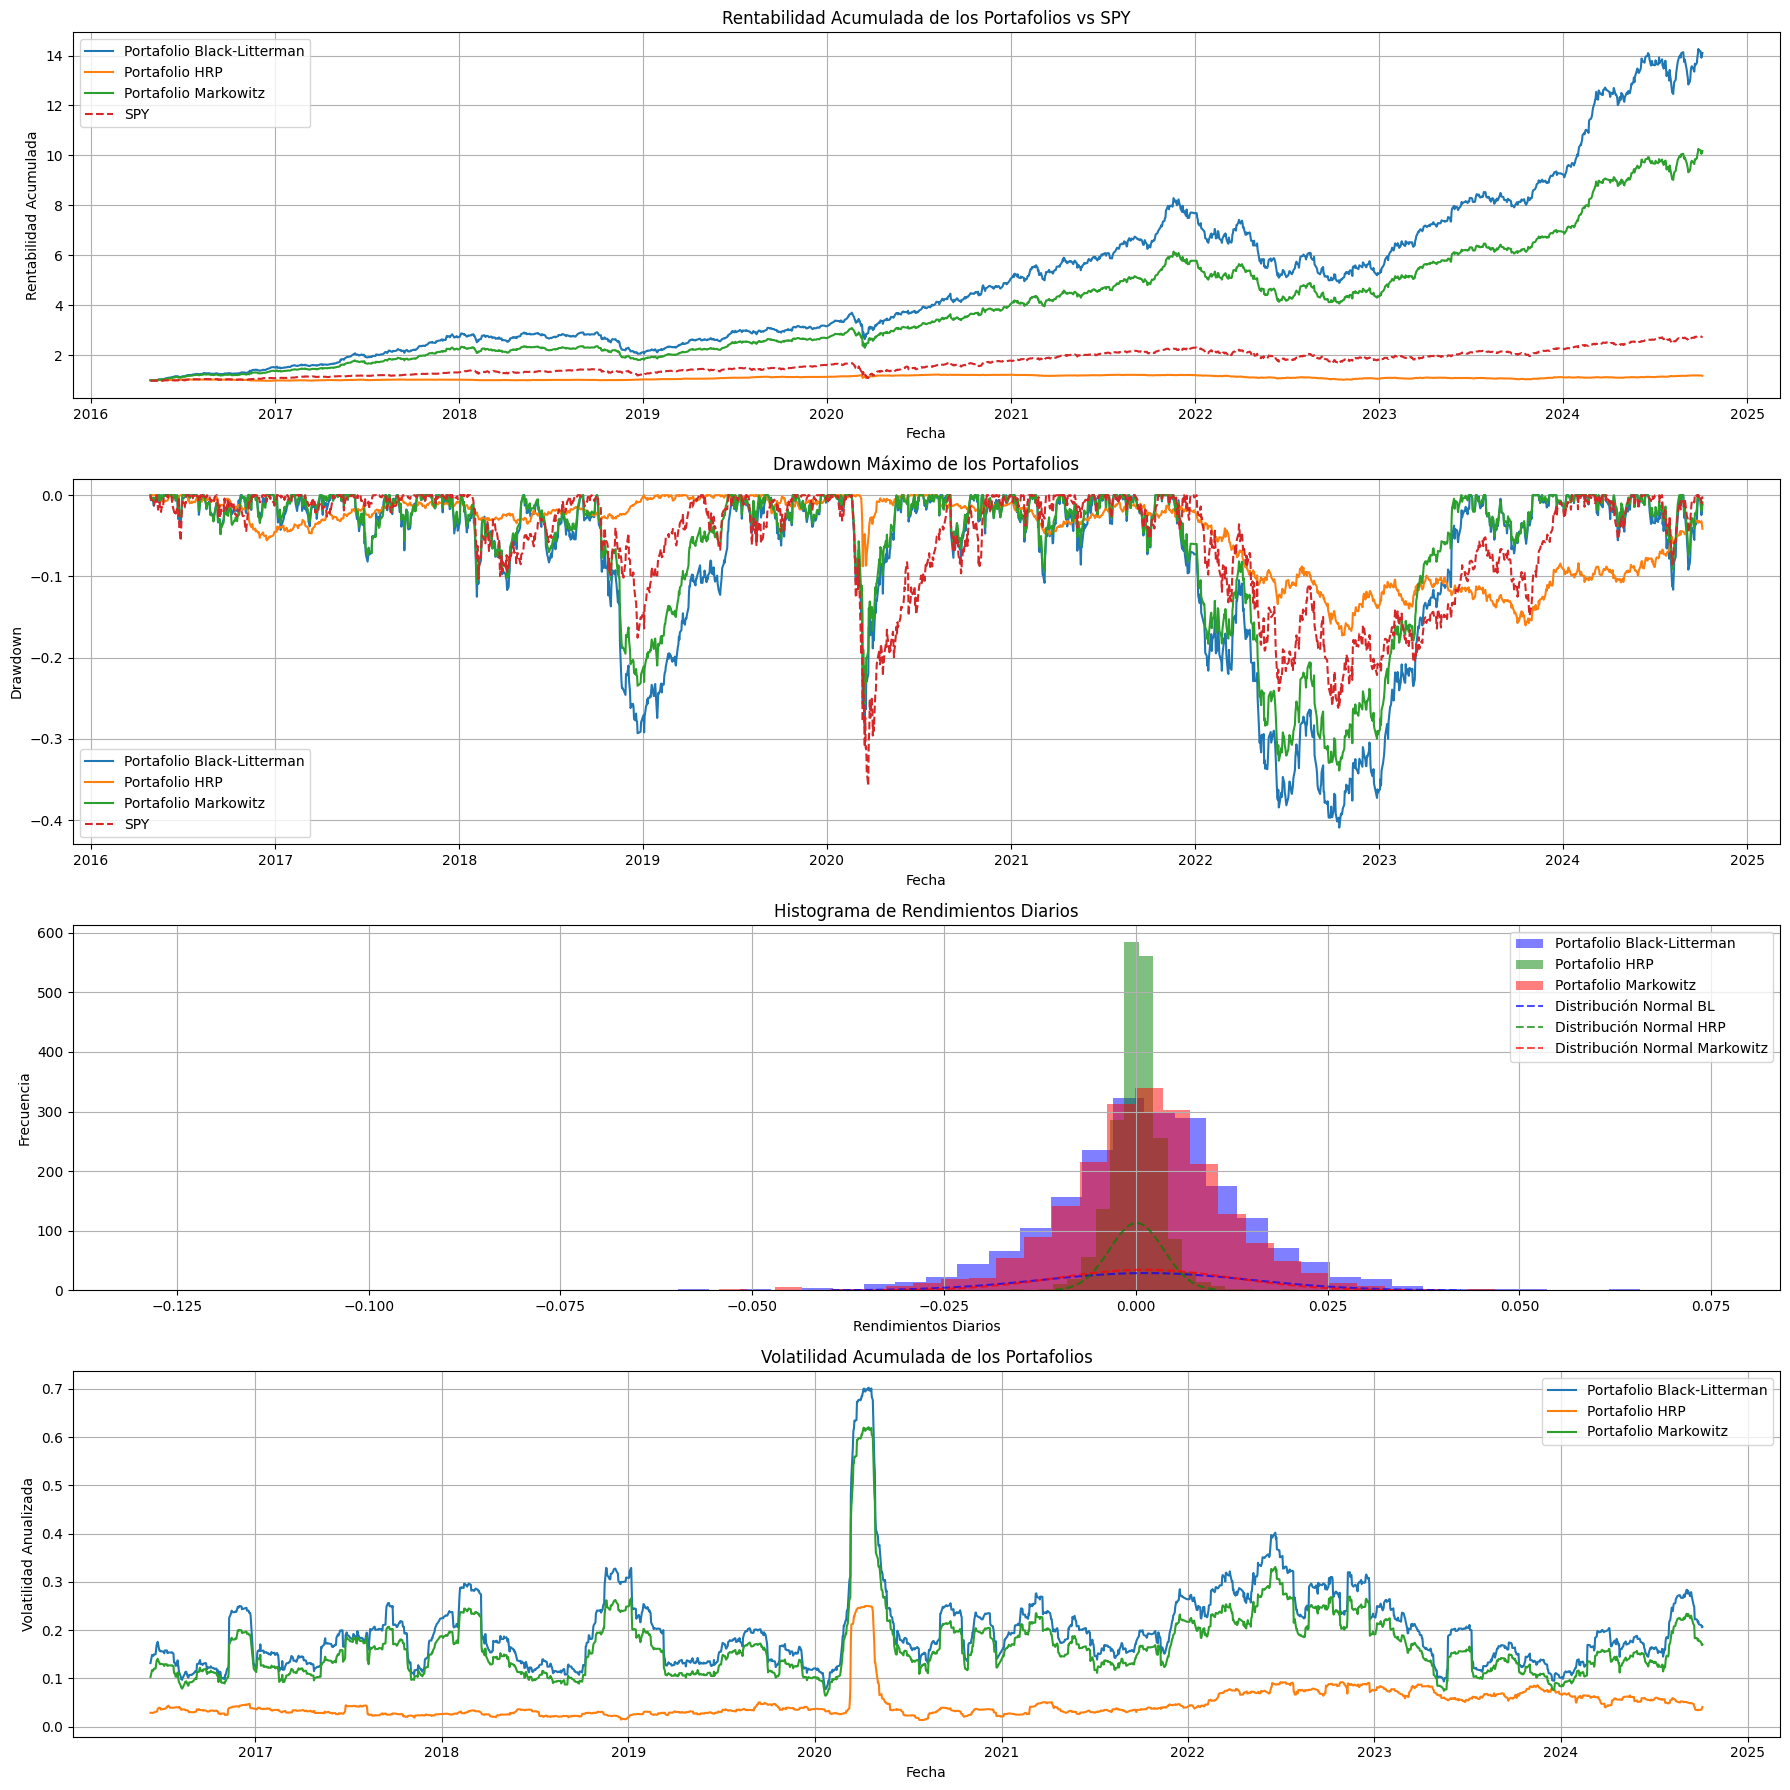

     Ticker  Black-Litterman      HRP  Markowitz
0      NVDA          0.25322  0.00000    0.18959
1      RACE          0.06808  0.00036    0.04497
2      MSFT          0.00000  0.00026    0.00000
3      COST          0.11116  0.00131    0.10204
4      GOOG          0.00000  0.00148    0.00000
5       WMT          0.07218  0.00269    0.09709
6      ORLY          0.00000  0.00214    0.00341
7       SMH          0.00000  0.00028    0.00000
8      AAPL          0.00000  0.00024    0.00000
9      AMZN          0.00000  0.00018    0.00000
10     META          0.00000  0.00021    0.00000
13   EGLN.L          0.18766  0.05327    0.24774
14      BND          0.00000  0.91831    0.00000
15  WCOA.MI          0.00000  0.00151    0.00000
16  BTC-EUR          0.12909  0.00000    0.10590
17  IWDA.AS          0.00000  0.00332    0.00000
18   RMS.PA          0.17861  0.00048    0.18059
19        O          0.00000  0.00574    0.00000
20    MC.PA          0.00000  0.00036    0.00000
21   IBE.MC         

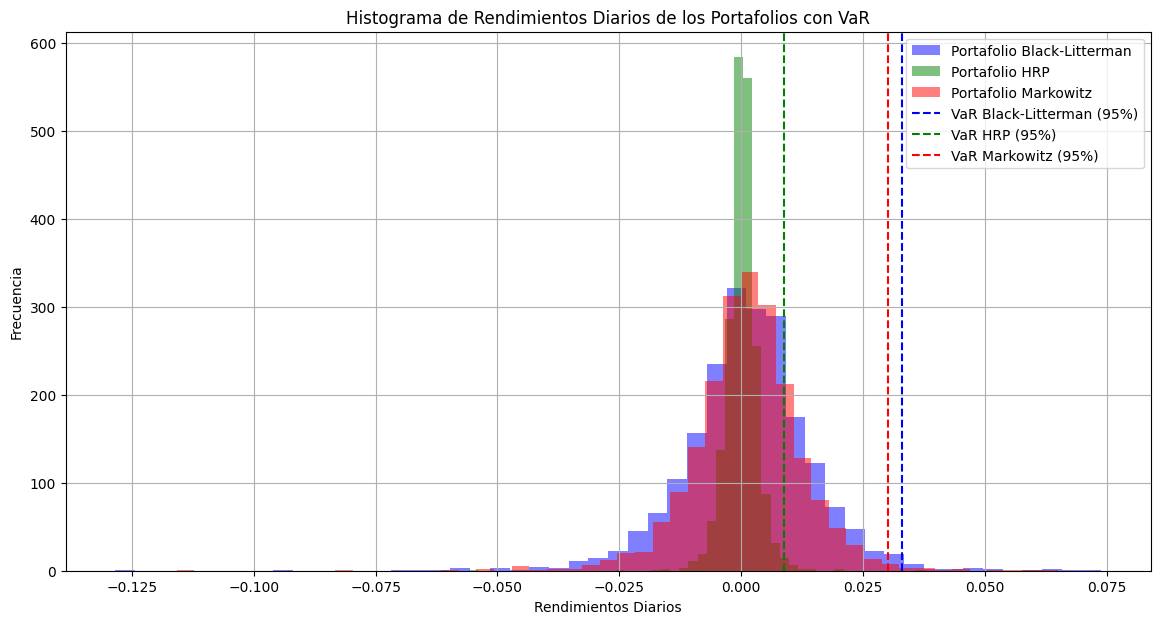

In [1]:
##################### MODELOS COMBINADOS Y MUCHOS GRAFICOS CON RESULTADOS #####################
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import risk_models, expected_returns, EfficientFrontier, HRPOpt
from scipy.stats import norm

# Configuración de variables
tickers = ['NVDA', 'RACE', 'MSFT', 'COST', 'GOOG', 'WMT', 'ORLY', 'SMH', 'AAPL', 'AMZN', 'META', 'NFLX', 'TSLA', 'EGLN.L', 'BND', 'WCOA.MI', 'BTC-EUR', 'IWDA.AS', 'RMS.PA', 'O','MC.PA','IBE.MC','TGT']
benchmark_ticker = 'SPY'
start_date = '2016-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
risk_free_rate = 0.0002083333  # Tasa libre de riesgo diaria

# Descargar datos
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)['Adj Close']
data = data.dropna(how='any')

# Calcular rendimientos
returns = np.log(data / data.shift(1)).dropna()

# Calcular rendimientos esperados y matriz de covarianza
mu = expected_returns.mean_historical_return(data[tickers])
S = risk_models.sample_cov(data[tickers])
S = (S + S.T) / 2  # Asegurar simetría

# Crear la matriz P y el vector Q para Black-Litterman
P = np.zeros((len(tickers), len(tickers)))
Q = np.zeros(len(tickers))
for i in range(len(tickers)):
    P[i, i] = 1
    P[i, -1] = -1
    Q[i] = mu[i] - mu[-1]  # Ajuste para ejemplos

# Configurar el parámetro tau
tau = 0.99  # Ajustar este valor entre 0 y 1

# Configurar el modelo Black-Litterman con las nuevas vistas
bl = BlackLittermanModel(S, pi=mu, P=P, Q=Q, tau=tau)
bl_return = bl.bl_returns()
bl_cov = bl.bl_cov()

# Calcular retornos excesivos y crear la instancia de EfficientFrontier
excess_returns = bl_return - risk_free_rate
ef_bl = EfficientFrontier(excess_returns, bl_cov)
bl_weights = ef_bl.max_sharpe()
bl_cleaned_weights = ef_bl.clean_weights()

# Filtrar pesos no nulos
bl_non_zero_weights = {k: v for k, v in bl_cleaned_weights.items() if v > 0}

# Model HRP
hrp = HRPOpt(S)
hrp_weights = hrp.optimize()
hrp_cleaned_weights = hrp.clean_weights()

# Filtrar pesos no nulos
hrp_non_zero_weights = {k: v for k, v in hrp_cleaned_weights.items() if v > 0}

# Model Markowitz
ef_markowitz = EfficientFrontier(mu, S)
markowitz_weights = ef_markowitz.max_sharpe()
markowitz_cleaned_weights = ef_markowitz.clean_weights()

# Filtrar pesos no nulos
markowitz_non_zero_weights = {k: v for k, v in markowitz_cleaned_weights.items() if v > 0}

# Calcular rendimientos optimizados de las carteras
bl_optimized_returns = returns[tickers].dot(pd.Series(bl_cleaned_weights))
hrp_optimized_returns = returns[tickers].dot(pd.Series(hrp_cleaned_weights))
markowitz_optimized_returns = returns[tickers].dot(pd.Series(markowitz_cleaned_weights))

# Calcular rendimiento acumulado
bl_comparison = pd.DataFrame({
    'Black-Litterman Portfolio': (1 + bl_optimized_returns).cumprod(),
    'SPY': (1 + returns[benchmark_ticker]).cumprod()
})

hrp_comparison = pd.DataFrame({
    'HRP Portfolio': (1 + hrp_optimized_returns).cumprod(),
    'SPY': (1 + returns[benchmark_ticker]).cumprod()
})

markowitz_comparison = pd.DataFrame({
    'Markowitz Portfolio': (1 + markowitz_optimized_returns).cumprod(),
    'SPY': (1 + returns[benchmark_ticker]).cumprod()
})

# Funciones de cálculo
def calculate_log_returns(comparison_df):
    log_returns = np.log(comparison_df / comparison_df.shift(1)).dropna()
    return log_returns

def calculate_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

def calculate_sortino_ratio(returns, risk_free_rate):
    downside_returns = returns[returns < risk_free_rate]
    expected_return = returns.mean()
    downside_std = downside_returns.std()
    sortino_ratio = (expected_return - risk_free_rate) / downside_std
    return sortino_ratio

def calculate_tracking_error(portfolio_returns, benchmark_returns):
    return np.sqrt(((portfolio_returns - benchmark_returns) ** 2).mean()) * np.sqrt(trading_days)

def calculate_portfolio_beta(portfolio_returns, benchmark_returns):
    cov_matrix = np.cov(portfolio_returns, benchmark_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    return beta

# Calcular log returns y drawdowns
bl_log_returns = calculate_log_returns(bl_comparison['Black-Litterman Portfolio'])
hrp_log_returns = calculate_log_returns(hrp_comparison['HRP Portfolio'])
markowitz_log_returns = calculate_log_returns(markowitz_comparison['Markowitz Portfolio'])

bl_drawdown = calculate_drawdown(bl_comparison['Black-Litterman Portfolio'])
hrp_drawdown = calculate_drawdown(hrp_comparison['HRP Portfolio'])
markowitz_drawdown = calculate_drawdown(markowitz_comparison['Markowitz Portfolio'])

# Calcular ratios y métricas
trading_days = 252

bl_sharpe_ratio = (bl_optimized_returns.mean() * trading_days - risk_free_rate) / (bl_optimized_returns.std() * np.sqrt(trading_days))
hrp_sharpe_ratio = (hrp_optimized_returns.mean() * trading_days - risk_free_rate) / (hrp_optimized_returns.std() * np.sqrt(trading_days))
markowitz_sharpe_ratio = (markowitz_optimized_returns.mean() * trading_days - risk_free_rate) / (markowitz_optimized_returns.std() * np.sqrt(trading_days))

bl_sortino_ratio = calculate_sortino_ratio(bl_optimized_returns, risk_free_rate)
hrp_sortino_ratio = calculate_sortino_ratio(hrp_optimized_returns, risk_free_rate)
markowitz_sortino_ratio = calculate_sortino_ratio(markowitz_optimized_returns, risk_free_rate)

bl_tracking_error = calculate_tracking_error(bl_optimized_returns, returns[benchmark_ticker])
hrp_tracking_error = calculate_tracking_error(hrp_optimized_returns, returns[benchmark_ticker])
markowitz_tracking_error = calculate_tracking_error(markowitz_optimized_returns, returns[benchmark_ticker])

bl_beta = calculate_portfolio_beta(bl_optimized_returns, returns[benchmark_ticker])
hrp_beta = calculate_portfolio_beta(hrp_optimized_returns, returns[benchmark_ticker])
markowitz_beta = calculate_portfolio_beta(markowitz_optimized_returns, returns[benchmark_ticker])

bl_volatility_annual = bl_optimized_returns.std() * np.sqrt(trading_days)
hrp_volatility_annual = hrp_optimized_returns.std() * np.sqrt(trading_days)
markowitz_volatility_annual = markowitz_optimized_returns.std() * np.sqrt(trading_days)

# Imprimir resultados de los modelos
print(f"\nSharpe Ratio del Modelo Black-Litterman: {bl_sharpe_ratio:.2f}")
print(f"Sortino Ratio del Modelo Black-Litterman: {bl_sortino_ratio:.2f}")
print(f"Tracking Error del Modelo Black-Litterman: {bl_tracking_error:.2%}")
print(f"Beta del Modelo Black-Litterman: {bl_beta:.2f}")
print(f"Volatilidad Anualizada del Modelo Black-Litterman: {bl_volatility_annual:.2f}")
print(f"Drawdown Máximo del Modelo Black-Litterman: {bl_drawdown.min():.2%}")

print(f"\nSharpe Ratio del Modelo HRP: {hrp_sharpe_ratio:.2f}")
print(f"Sortino Ratio del Modelo HRP: {hrp_sortino_ratio:.2f}")
print(f"Tracking Error del Modelo HRP: {hrp_tracking_error:.2%}")
print(f"Beta del Modelo HRP: {hrp_beta:.2f}")
print(f"Volatilidad Anualizada del Modelo HRP: {hrp_volatility_annual:.2f}")
print(f"Drawdown Máximo del Modelo HRP: {hrp_drawdown.min():.2%}")

print(f"\nSharpe Ratio del Modelo Markowitz: {markowitz_sharpe_ratio:.2f}")
print(f"Sortino Ratio del Modelo Markowitz: {markowitz_sortino_ratio:.2f}")
print(f"Tracking Error del Modelo Markowitz: {markowitz_tracking_error:.2%}")
print(f"Beta del Modelo Markowitz: {markowitz_beta:.2f}")
print(f"Volatilidad Anualizada del Modelo Markowitz: {markowitz_volatility_annual:.2f}")
print(f"Drawdown Máximo del Modelo Markowitz: {markowitz_drawdown.min():.2%}")

# Análisis de Performance
def performance_analysis(returns, weights):
    portfolio_returns = returns[tickers].dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    annualized_return = cumulative_returns[-1] ** (252 / len(returns)) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (portfolio_returns.mean() * 252 - risk_free_rate) / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

# Análisis para cada modelo
bl_annual_return, bl_annual_volatility, bl_sharpe = performance_analysis(returns, pd.Series(bl_cleaned_weights))
hrp_annual_return, hrp_annual_volatility, hrp_sharpe = performance_analysis(returns, pd.Series(hrp_cleaned_weights))
markowitz_annual_return, markowitz_annual_volatility, markowitz_sharpe = performance_analysis(returns, pd.Series(markowitz_cleaned_weights))

print(f"\nRendimiento Anualizado del Modelo Black-Litterman: {bl_annual_return:.2%}")
print(f"Volatilidad Anualizada del Modelo Black-Litterman: {bl_annual_volatility:.2%}")
print(f"Sharpe Ratio del Modelo Black-Litterman (Anualizado): {bl_sharpe:.2f}")

print(f"\nRendimiento Anualizado del Modelo HRP: {hrp_annual_return:.2%}")
print(f"Volatilidad Anualizada del Modelo HRP: {hrp_annual_volatility:.2%}")
print(f"Sharpe Ratio del Modelo HRP (Anualizado): {hrp_sharpe:.2f}")

print(f"\nRendimiento Anualizado del Modelo Markowitz: {markowitz_annual_return:.2%}")
print(f"Volatilidad Anualizada del Modelo Markowitz: {markowitz_annual_volatility:.2%}")
print(f"Sharpe Ratio del Modelo Markowitz (Anualizado): {markowitz_sharpe:.2f}")

# Simulación de Monte Carlo
num_simulations = 1000
simulated_returns = {'Black-Litterman': [], 'HRP': [], 'Markowitz': []}

for _ in range(num_simulations):
    simulated_weights_bl = np.random.dirichlet(np.ones(len(tickers)))
    simulated_weights_hrp = np.random.dirichlet(np.ones(len(tickers)))
    simulated_weights_markowitz = np.random.dirichlet(np.ones(len(tickers)))

    simulated_portfolio_returns_bl = returns[tickers].dot(simulated_weights_bl)
    simulated_portfolio_returns_hrp = returns[tickers].dot(simulated_weights_hrp)
    simulated_portfolio_returns_markowitz = returns[tickers].dot(simulated_weights_markowitz)
    
    simulated_returns['Black-Litterman'].append(simulated_portfolio_returns_bl.mean() * trading_days)
    simulated_returns['HRP'].append(simulated_portfolio_returns_hrp.mean() * trading_days)
    simulated_returns['Markowitz'].append(simulated_portfolio_returns_markowitz.mean() * trading_days)

plt.figure(figsize=(14, 7))
for label, data in simulated_returns.items():
    mu, std = np.mean(data), np.std(data)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    pdf = norm.pdf(x, mu, std)
    plt.hist(data, bins=50, alpha=0.5, label=f'Simulación {label}')
    plt.plot(x, pdf, color='red', linestyle='--', alpha=0.7, label=f'Distribución Normal {label}')
plt.title('Distribución de Rendimientos Simulados')
plt.xlabel('Rendimiento Anualizado')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()

# Visualización de Performance Ajustada por Riesgo
returns_volatility = {
    'Black-Litterman': (bl_annual_return, bl_annual_volatility),
    'HRP': (hrp_annual_return, hrp_annual_volatility),
    'Markowitz': (markowitz_annual_return, markowitz_annual_volatility),
}

plt.figure(figsize=(10, 6))
for label, (ret, vol) in returns_volatility.items():
    plt.scatter(vol, ret, label=label)
plt.title('Retorno vs Volatilidad')
plt.xlabel('Volatilidad Anualizada')
plt.ylabel('Retorno Anualizado')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las rentabilidades acumuladas, drawdowns, y volatilidad
plt.figure(figsize=(18, 18))

# Rentabilidades acumuladas
plt.subplot(4, 1, 1)
plt.plot(bl_comparison['Black-Litterman Portfolio'], label='Portafolio Black-Litterman')
plt.plot(hrp_comparison['HRP Portfolio'], label='Portafolio HRP')
plt.plot(markowitz_comparison['Markowitz Portfolio'], label='Portafolio Markowitz')
plt.plot((1 + returns[benchmark_ticker]).cumprod(), label='SPY', linestyle='--')
plt.title('Rentabilidad Acumulada de los Portafolios vs SPY')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad Acumulada')
plt.legend()
plt.grid(True)

# Drawdowns
plt.subplot(4, 1, 2)
plt.plot(bl_drawdown, label='Portafolio Black-Litterman')
plt.plot(hrp_drawdown, label='Portafolio HRP')
plt.plot(markowitz_drawdown, label='Portafolio Markowitz')
plt.plot(calculate_drawdown((1 + returns[benchmark_ticker]).cumprod()), label='SPY', linestyle='--')
plt.title('Drawdown Máximo de los Portafolios')
plt.xlabel('Fecha')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)

# Histograma de rendimientos diarios
plt.subplot(4, 1, 3)
plt.hist(bl_optimized_returns, bins=50, alpha=0.5, label='Portafolio Black-Litterman', color='blue')
plt.hist(hrp_optimized_returns, bins=50, alpha=0.5, label='Portafolio HRP', color='green')
plt.hist(markowitz_optimized_returns, bins=50, alpha=0.5, label='Portafolio Markowitz', color='red')
mu_bl, std_bl = bl_optimized_returns.mean(), bl_optimized_returns.std()
mu_hrp, std_hrp = hrp_optimized_returns.mean(), hrp_optimized_returns.std()
mu_markowitz, std_markowitz = markowitz_optimized_returns.mean(), markowitz_optimized_returns.std()
x_bl = np.linspace(mu_bl - 3*std_bl, mu_bl + 3*std_bl, 100)
x_hrp = np.linspace(mu_hrp - 3*std_hrp, mu_hrp + 3*std_hrp, 100)
x_markowitz = np.linspace(mu_markowitz - 3*std_markowitz, mu_markowitz + 3*std_markowitz, 100)
plt.plot(x_bl, norm.pdf(x_bl, mu_bl, std_bl), color='blue', linestyle='--', alpha=0.7, label='Distribución Normal BL')
plt.plot(x_hrp, norm.pdf(x_hrp, mu_hrp, std_hrp), color='green', linestyle='--', alpha=0.7, label='Distribución Normal HRP')
plt.plot(x_markowitz, norm.pdf(x_markowitz, mu_markowitz, std_markowitz), color='red', linestyle='--', alpha=0.7, label='Distribución Normal Markowitz')
plt.title('Histograma de Rendimientos Diarios')
plt.xlabel('Rendimientos Diarios')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)

# Volatilidad acumulada
plt.subplot(4, 1, 4)
plt.plot(bl_optimized_returns.rolling(window=30).std() * np.sqrt(trading_days), label='Portafolio Black-Litterman')
plt.plot(hrp_optimized_returns.rolling(window=30).std() * np.sqrt(trading_days), label='Portafolio HRP')
plt.plot(markowitz_optimized_returns.rolling(window=30).std() * np.sqrt(trading_days), label='Portafolio Markowitz')
plt.title('Volatilidad Acumulada de los Portafolios')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad Anualizada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Crear un DataFrame con los pesos de cada modelo
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Black-Litterman': [bl_cleaned_weights.get(ticker, 0) for ticker in tickers],
    'HRP': [hrp_cleaned_weights.get(ticker, 0) for ticker in tickers],
    'Markowitz': [markowitz_cleaned_weights.get(ticker, 0) for ticker in tickers]
})

# Filtrar solo los tickers con pesos positivos en al menos uno de los modelos
weights_df = weights_df.loc[(weights_df[['Black-Litterman', 'HRP', 'Markowitz']] > 0).any(axis=1)]

# Mostrar el DataFrame con los pesos
print(weights_df)

def calculate_var(returns, confidence_level=0.99):
    return -np.percentile(returns, (1 - confidence_level) * 100)

bl_var = calculate_var(bl_optimized_returns)
hrp_var = calculate_var(hrp_optimized_returns)
markowitz_var = calculate_var(markowitz_optimized_returns)

plt.figure(figsize=(14, 7))
plt.hist(bl_optimized_returns, bins=50, alpha=0.5, label='Portafolio Black-Litterman', color='blue')
plt.hist(hrp_optimized_returns, bins=50, alpha=0.5, label='Portafolio HRP', color='green')
plt.hist(markowitz_optimized_returns, bins=50, alpha=0.5, label='Portafolio Markowitz', color='red')

# Añadir líneas de VaR
plt.axvline(x=bl_var, color='blue', linestyle='--', label=f'VaR Black-Litterman (95%)')
plt.axvline(x=hrp_var, color='green', linestyle='--', label=f'VaR HRP (95%)')
plt.axvline(x=markowitz_var, color='red', linestyle='--', label=f'VaR Markowitz (95%)')

plt.title('Histograma de Rendimientos Diarios de los Portafolios con VaR')
plt.xlabel('Rendimientos Diarios')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()




In [15]:
###################### HRP ######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt
import seaborn as sns

pypfopt.__version__

'1.5.5'

In [16]:
tickers = ["MSFT","COST","PEP","RACE"]

ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  4 of 4 completed


Ticker,COST,MSFT,PEP,RACE
Date,,,,
2024-09-30,886.520020,430.299988,170.050003,470.109985
2024-10-01,877.380005,420.690002,171.380005,455.859985
2024-10-02,878.530029,417.130005,169.550003,457.160004
2024-10-03,875.669983,416.540009,168.529999,450.089996
2024-10-04,883.109985,416.059998,167.970001,449.809998


In [18]:
from pypfopt import expected_returns

rets = expected_returns.returns_from_prices(prices)
rets.tail()

Ticker,COST,MSFT,PEP,RACE
Date,,,,
2024-09-30,0.001016,0.005327,0.000294,-0.003329
2024-10-01,-0.010310,-0.022333,0.007821,-0.030312
2024-10-02,0.001311,-0.008462,-0.010678,0.002852
2024-10-03,-0.003255,-0.001414,-0.006016,-0.015465
2024-10-04,0.008496,-0.001152,-0.003323,-0.000622


In [19]:
from pypfopt import HRPOpt
     
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights
     


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60152546 0.60152546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


OrderedDict([('COST', 0.22521),
             ('MSFT', 0.17691),
             ('PEP', 0.37632),
             ('RACE', 0.22156)])

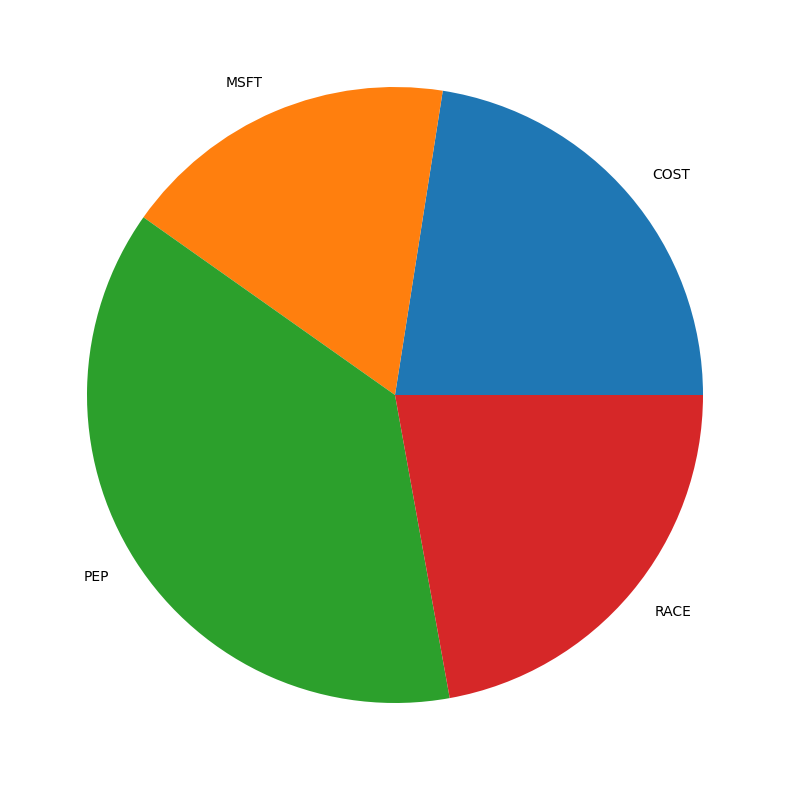

In [20]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [21]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 20.8%
Annual volatility: 19.9%
Sharpe Ratio: 0.94


In [2]:
########################### BLACK-LITTERMAN #####################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "COST","PEP","RACE"]
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  4 of 4 completed


Ticker,COST,MSFT,PEP,RACE
Date,,,,
2024-09-30,886.520020,430.299988,170.050003,470.109985
2024-10-01,877.380005,420.690002,171.380005,455.859985
2024-10-02,878.530029,417.130005,169.550003,457.160004
2024-10-03,875.669983,416.540009,168.529999,450.089996
2024-10-04,883.109985,416.059998,167.970001,449.809998


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    24.608629
1993-02-01    24.783648
1993-02-02    24.836153
1993-02-03    25.098705
1993-02-04    25.203699
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3092590624768,
 'COST': 391329021952,
 'PEP': 230718570496,
 'RACE': 80696360960}

In [6]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.786222838165715

In [7]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
COST    0.103907
MSFT    0.217989
PEP     0.076464
RACE    0.038818
dtype: float64

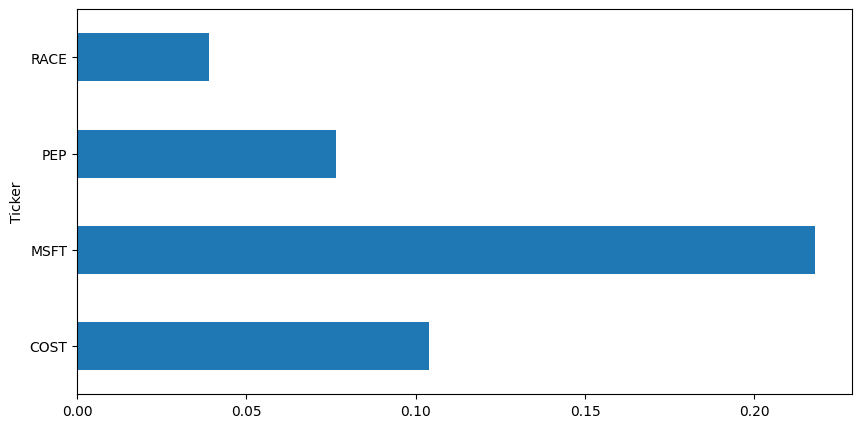

In [8]:
market_prior.plot.barh(figsize=(10,5));

In [9]:
viewdict = {
    "MSFT": 0.60, #PIENSO QUE MSFT SUBIRA UN 60%
    "COST": 0.50,
    "PEP": 0.24,
    "RACE": 0.45,
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [10]:
confidences = [
    0.3, #LA CONFIANZA QUE TENGO EN QUE MSFT LO HAGA COMO DIJE EN LA CELDA ANTERIOR
    0.1,
    0.7,
    0.8,
]

In [11]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [12]:
np.diag(bl.omega)

array([0.00959835, 0.03228762, 0.00126099, 0.00019405])

In [13]:
# ESTIMACIONES POSTERIORES DE LOS RETORNOS
ret_bl = bl.bl_returns()
ret_bl

Ticker
COST    0.249169
MSFT    0.455492
PEP     0.216149
RACE    0.369738
dtype: float64

In [14]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
COST,0.103907,0.249169,0.50
MSFT,0.217989,0.455492,0.60
PEP,0.076464,0.216149,0.24
RACE,0.038818,0.369738,0.45


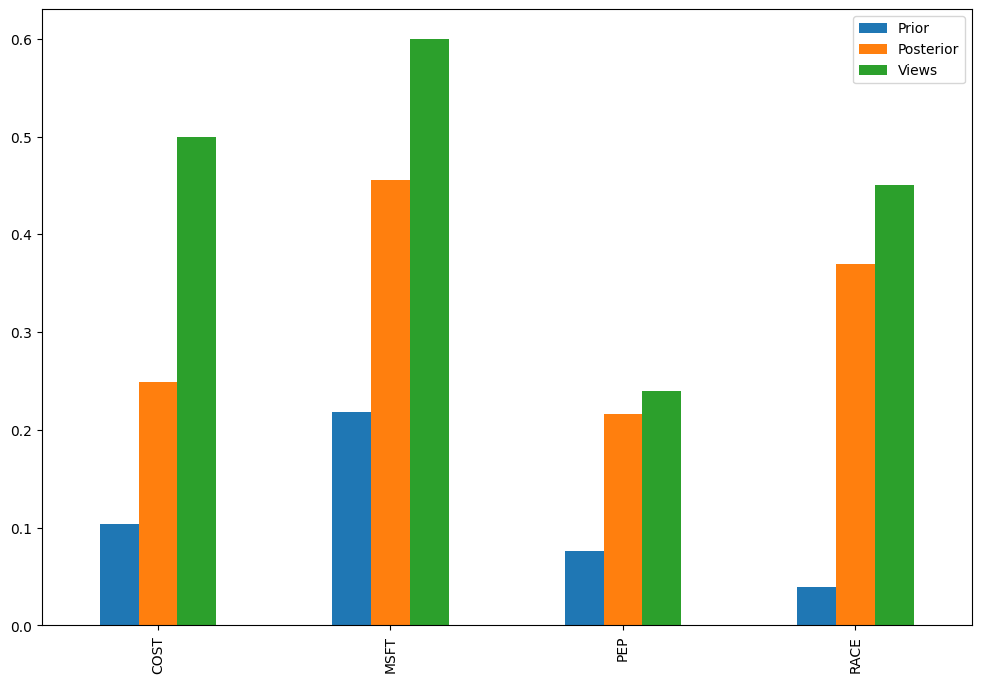

In [15]:
rets_df.plot.bar(figsize=(12,8));

In [16]:
#LOS RETORNOS NO LLEGARON A SER TAN BUENOS COMO PLANTEE AL COMIENZO

In [23]:
#PONDERACION DE ACTIVOS EN LA CARTERA CON 5000$

from pypfopt import EfficientFrontier, objective_functions
S_bl = bl.bl_cov()

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('COST', 0.18052),
             ('MSFT', 0.35389),
             ('PEP', 0.15773),
             ('RACE', 0.30787)])

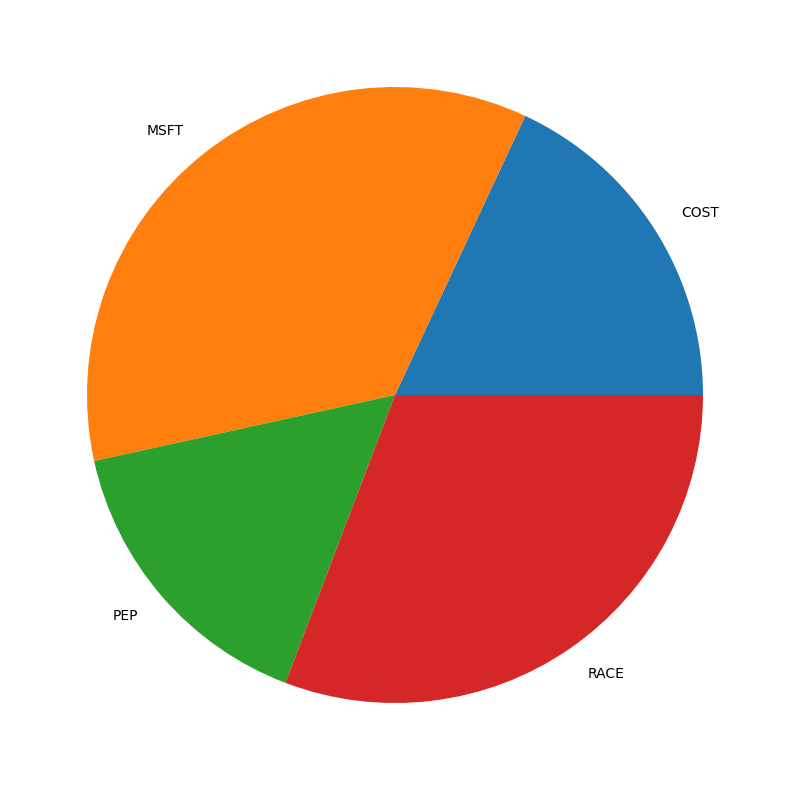

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=5000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $95.40


{'COST': 1, 'MSFT': 4, 'PEP': 6, 'RACE': 3}

[*********************100%%**********************]  4 of 4 completed


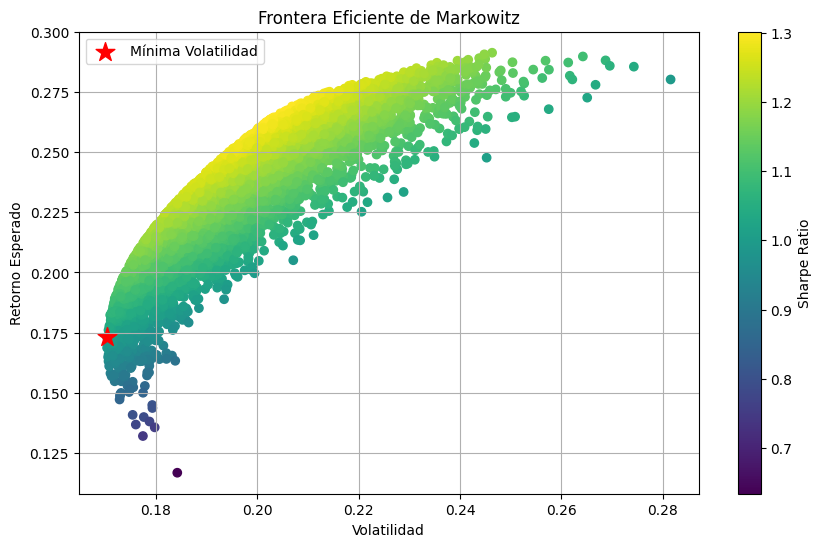

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


tickers = ['MSFT', 'COST', 'PEP', 'RACE']
data = yf.download(tickers, period="max")['Adj Close']

# CALCULO DE LOS RETORNOS LOGARITMICOS
returns = data.pct_change().dropna()

# CALCULO DE MEDIA DE RETORNOS Y COVARIANZA DE LOS MISMOS
mean_returns = returns.mean()
cov_matrix = returns.cov()

# SIMULACION DE CARTERAS
num_portfolios = 10000
results = np.zeros((4, num_portfolios))

np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(weights * mean_returns) * 252  # RETORNO ANUALIZADO
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # VOLATILIDAD ANUALIZADA
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    results[3, i] = i  # INDICE DE LA CARTERA

# COMO HALLAR LA CARTERA DE MINIMA VARIANZA
min_volatility_idx = results[1].argmin()
min_volatility_return = results[0, min_volatility_idx]
min_volatility_volatility = results[1, min_volatility_idx]

# Graficar la EF
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# GRAFICO DE LA CARTERA MINIMA VARIANZA
plt.scatter(min_volatility_volatility, min_volatility_return, color='r', marker='*', s=200, label='Mínima Volatilidad')

plt.title('Frontera Eficiente de Markowitz')
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Esperado')
plt.legend(loc='best')
plt.grid(True)
plt.show()


[*********************100%%**********************]  4 of 4 completed


Rentabilidad de la cartera de mínima volatilidad: 0.1492
Volatilidad de la cartera de mínima volatilidad: 0.1706
Ratio Sharpe de la cartera de mínima volatilidad: 0.8746


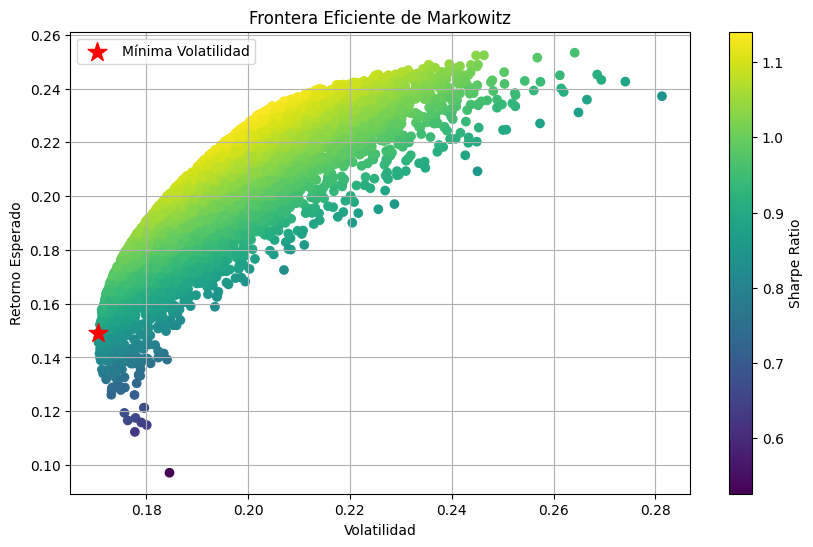

In [36]:
############################### CARTERA DE MINIMA VARIANZA DE MARKOWITZ ########################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# DESCARGA DE TICKERS
tickers = ['MSFT', 'COST', 'PEP', 'RACE']
data = yf.download(tickers, period="max")['Adj Close']

# CALCULO DE LOS RETORNOS LOGARITMICOS
log_returns = np.log(data / data.shift(1)).dropna()

# CALCULO DE MEDIA DE RETORNOS Y COVARIANZA DE LOS MISMOS
mean_log_returns = log_returns.mean()
cov_matrix = log_returns.cov()

# SIMULACION DE CARTERAS
num_portfolios = 10000
results = np.zeros((4, num_portfolios))

np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(weights * mean_log_returns) * 252  # RETORNO ANUALIZADO
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # VOLATILIDAD ANUALIZADA
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    results[3, i] = i  # INDICE DE LA CARTERA

# COMO HALLAR LA CARTERA DE MINIMA VARIANZA
min_volatility_idx = results[1].argmin()
min_volatility_return = results[0, min_volatility_idx]
min_volatility_volatility = results[1, min_volatility_idx]
min_volatility_sharpe = results[2, min_volatility_idx]

# PRINT DE LA RENTABILIDAD,VOLATILIDAD Y SHARPE DE LA CARTERA
print(f"Rentabilidad de la cartera de mínima volatilidad: {min_volatility_return:.4f}")
print(f"Volatilidad de la cartera de mínima volatilidad: {min_volatility_volatility:.4f}")
print(f"Ratio Sharpe de la cartera de mínima volatilidad: {min_volatility_sharpe:.4f}")

# GRAFICO DE LA FRONTERA EFICIENTE
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# GRAFICO DE LA CARTERA MINIMA VARIANZA
plt.scatter(min_volatility_volatility, min_volatility_return, color='r', marker='*', s=200, label='Mínima Volatilidad')

plt.title('Frontera Eficiente de Markowitz')
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Esperado')
plt.legend(loc='best')
plt.grid(True)
plt.show()
